## External Preference Mapping (EPM) with Simulated Chocolate Data  

This notebook explores how **External Preference Mapping (EPM)** can be implemented in Python to relate sensory product profiles to simulated consumer liking data.  
EPM combines **Descriptive Analysis (DA)** data with **consumer preference scores** and is often analyzed using **Partial Least Squares Regression (PLS-R)** (Drake, Watson, & Liu, *Annual Review of Food Science and Technology*, 2024).  

Here, we simulate this analysis using DA data for six chocolate types and Python/scikit-learn’s PLS-R implementation.  
Currently, the notebook focuses on simulating and preprocessing liking data (including age effects and mean-centering), with PLS-R modeling and visualization to follow.  

**Description of Data**
- The sensochoc dataset contains sensory description of six types of chocolate. 
- Each type was evaluated twice by 29 panelists according to 14 sensory descriptors (listed in `cols` below).

---

## Setup

- Import packages
- Read in sensochoc data borrowed from the R package [`sensehubr`](https://github.com/aswansyahputra/sensehubr)

In [67]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# project root
repo_root = Path().resolve().parent

# CSV path
CSV_PATH = repo_root / "data" / "sensochoc_dataset.csv"
assert CSV_PATH.exists(), f"CSV file not found: {CSV_PATH}"

# read CSV
df_original = pd.read_csv(CSV_PATH)

# check
df_original

,Unnamed: 0,panelist,session,rank,product,cocoa_a,milk_a,cocoa_f,milk_f,caramel,vanilla,sweetness,acidity,bitterness,astringency,crunchy,melting,sticky,granular
0,1,id_001,session_01,order_01,choc6,7,6,6,5,5,3,7,2,4,5,8,3,4,3
1,2,id_001,session_01,order_06,choc3,6,7,2,7,8,4,7,2,2,3,3,8,6,5
2,3,id_001,session_01,order_03,choc2,8,6,5,4,7,4,5,5,6,6,7,5,4,3
3,4,id_001,session_01,order_05,choc1,7,8,8,3,3,2,4,7,8,6,3,2,3,5
4,5,id_001,session_01,order_02,choc4,8,5,4,4,4,4,5,6,6,4,6,3,7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,344,id_029,session_02,order_04,choc5,5,7,9,6,2,0,2,1,7,6,1,8,0,0
344,345,id_029,session_02,order_03,choc2,1,2,8,2,1,0,3,6,5,5,9,3,0,0
345,346,id_029,session_02,order_01,choc6,8,3,8,1,1,0,6,1,5,3,7,7,1,0
346,347,id_029,session_02,order_02,choc4,3,7,3,5,7,4,6,0,2,1,1,7,0,0


---

## Sensory Data Preprocessing

To estimate the sensory profile of each of the six chocolate types, the data will be aggregated in two steps:

1) The 14 ratings provided by each participant will be averaged across the two timepoints
2) The averaged ratings for the 29 panelists will be averaged across each chocolate type

These steps create a data.frame with **one row for each of the six chocolates**.

In [21]:
# columns that will be aggregated
cols = ['cocoa_a','milk_a','cocoa_f','milk_f','caramel','vanilla','sweetness',
        'acidity','bitterness','astringency','crunchy','melting','sticky','granular']

# aggreage across time points (average the two evaluations per panelist × product)
df_panelist_product = df_original.groupby(['panelist','product'], as_index=False)[cols].mean()

# aggregate across panelist (average the 29 panelists for each product)
df_product = df_panelist_product.groupby(['product'], as_index=False)[cols].mean()

# check
print("Any NaNs?", df_original[cols].isna().any().any())
print("Original rows:", df_original.shape[0])
print("Rows after avg across timepoints:", df_panelist_product.shape[0])
print("Rows after avg across panelists:", df_product.shape[0])
df_product

Any NaNs? False
Original rows: 348
Rows after avg across timepoints: 174
Rows after avg across panelists: 6


,product,cocoa_a,milk_a,cocoa_f,milk_f,caramel,vanilla,sweetness,acidity,bitterness,astringency,crunchy,melting,sticky,granular
0,choc1,7.086207,3.586207,8.068966,1.568966,1.672414,1.103448,3.137931,4.655172,7.068966,4.758621,5.965517,4.741379,3.758621,3.448276
1,choc2,6.551724,4.000000,6.913793,2.379310,2.775862,1.810345,4.620690,3.137931,4.948276,3.155172,7.706897,4.327586,3.827586,3.155172
2,choc3,4.672414,6.051724,3.379310,7.706897,6.327586,3.672414,7.603448,1.568966,1.396552,1.206897,2.982759,7.310345,5.034483,1.603448
3,choc4,6.258621,4.103448,6.689655,2.586207,2.672414,2.120690,4.293103,3.931034,5.189655,3.689655,6.103448,4.379310,4.103448,3.551724
4,choc5,6.793103,4.172414,6.793103,3.120690,3.413793,1.793103,5.224138,3.086207,4.879310,3.103448,6.637931,4.741379,3.224138,3.068966
5,choc6,6.362069,4.568966,6.224138,3.362069,3.258621,1.913793,5.620690,2.672414,4.189655,2.758621,7.327586,4.206897,3.931034,3.172414


---
## Simulated Liking Data Preprocessing

The goal of this exercise is to explore the usage of partial least square regression with the sensory data above combined with product liking ratings from consumers. Because the sensochoc dataset does not contain such consumer information, we will simulate them in a roughly ecological manner. 

We generate liking scores based on its `sweetness`, `bitterness`, and `astringency`, and include `age` in the calculation to approximate how younger people prefer sweeter flavors. To control for individual differences in rating behavior, we mean-center the raw liking ratings per person.

In [101]:
# set seed for reproduciblity
np.random.seed(42)

# person-level data
n_persons = 138
ages = np.random.randint(5, 75, n_persons)
pids = np.arange(1, n_persons + 1)      

# product series
product = [f"choc{i}" for i in range(1, 7)]

# function to simulate liking
def liking_f(choc, age):
    liking = (
    0.5 * df_product.loc[df_product['product'] == prod, 'sweetness'].iloc[0] # sweetness is liked
    - 0.4 * df_product.loc[df_product['product']==prod, 'bitterness'].iloc[0] # bitterness is not liked
    - 0.2 * df_product.loc[df_product['product']==prod, 'astringency'].iloc[0] # astringency is not liked
    + 0.025 * (75 - age)  # younger gets a sweetness boost
    + np.random.normal(0, 0.5) # noise
    )
    return liking
    
# nested loop to simulate date
results = []
for pid, age in zip(pids, ages):
    for prod in product:
        liking = liking_f(prod, age)
        results.append((pid, age, prod, liking))

# result
liking_df = pd.DataFrame(results, columns=["person_id","age", "product", "liking"])

# rescale to remove negative values
abs_min_liking = abs(min(liking_df['liking']))
liking_df['liking'] = liking_df['liking'] + abs_min_liking + 0.5

# center liking scores by individual
liking_df["liking_centered"] = liking_df["liking"] - liking_df.groupby("person_id")["liking"].transform("mean")

# check
liking_df

,person_id,age,product,liking,liking_centered
0,1,56,choc1,2.514183,-1.230086
1,1,56,choc2,3.375302,-0.368967
2,1,56,choc3,6.300201,2.555931
3,1,56,choc4,2.676052,-1.068218
4,1,56,choc5,3.550064,-0.194205
...,...,...,...,...,...
823,138,13,choc2,4.772867,-0.248171
824,138,13,choc3,8.073904,3.052867
825,138,13,choc4,3.857839,-1.163199
826,138,13,choc5,4.749630,-0.271407


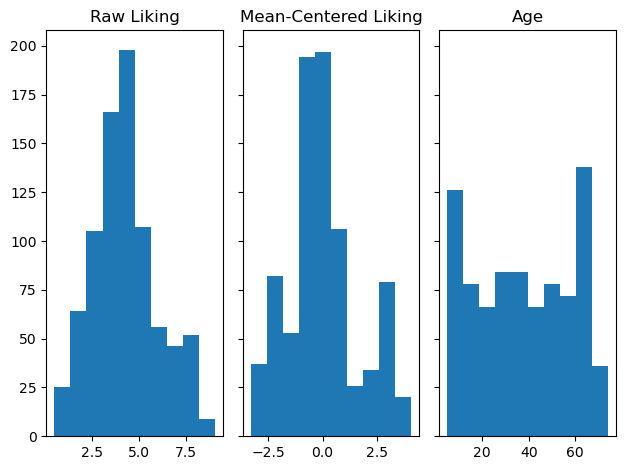

In [108]:
# visualize liking, liking_centered scores and age
# be aware there are 6 replicated per person in these charts

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)

# histogram for raw liking
axs[0].hist(liking_df['liking'], bins= 10)
axs[0].set_title("Raw Liking")

# histogram for mean-centered liking
axs[1].hist(liking_df['liking_centered'], bins= 10)
axs[1].set_title("Mean-Centered Liking")

# histogram of age distribution
axs[2].hist(liking_df['age'], bins= 10) # be aware there are 6 replicated per person in this chart
axs[2].set_title("Age")


plt.show()